This notebook serves as a case study for New Yorker.

Maher Nadar.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rich import inspect
import pymc as pm
import scipy
import math
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant

# Pricing

Our marketing manager was surveying the willingness to buy one of our fashion items at a certain price. They discovered the demand quantities, i.e. the number of people willing to buy, at various price levels. We have them below in two arrays. 

Assumptions: <br>

- we have endless enough supply to satisfy any demand --> no constraint on the total purchases of the items being sold by 'New Yorker'.
- the demand gathered by the marketing surveys are considered to be the upper bounds of the potential sales, because the 

In [3]:
pricing_df = pd.DataFrame(
    {
        "price": [100, 90, 70, 60, 40, 20, 10],
        "demand": [100, 120, 200, 300, 1200, 2000, 2800],
    }
)

In [4]:
pricing_df["revenue"] = pricing_df.eval(" price * demand ")

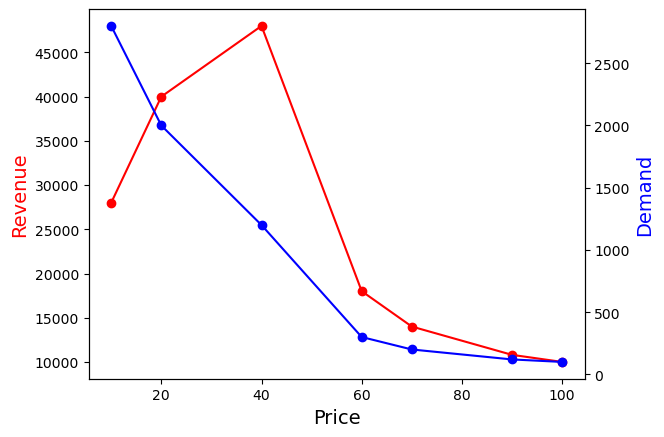

In [5]:
# create figure and axis objects with subplots()
fig, ax = plt.subplots()
# make a plot
ax.plot(pricing_df["price"], pricing_df["revenue"], color="red", marker="o", label="Revenue")
# set x-axis label
ax.set_xlabel("Price", fontsize=14)
# set y-axis label
ax.set_ylabel("Revenue", color="red", fontsize=14)


ax2 = ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(pricing_df["price"], pricing_df["demand"], color="blue", marker="o", label="Demand")
ax2.set_ylabel("Demand", color="blue", fontsize=14)

plt.show()

### Progressive discount price calculation

In [6]:
def calculate_total_cost(demand):
    # Define price tiers and their corresponding quantities
    price_tiers = [(50, 15), (100, 12), (200, 8), (np.inf, 4)]

    total_cost = 0

    # Calculate total cost based on quantity and price tiers
    for tier_quantity, tier_price in price_tiers:
        if demand > tier_quantity:
            total_cost += tier_quantity * tier_price
            demand -= tier_quantity
        else:
            total_cost += demand * tier_price
            break

    return total_cost

In [7]:
pricing_df["cost"] = pricing_df.demand.apply(calculate_total_cost)
pricing_df["profit"] = pricing_df.eval("price * demand - cost")
pricing_df

,price,demand,revenue,cost,profit
0,100,100,10000,1350,8650
1,90,120,10800,1590,9210
2,70,200,14000,2350,11650
3,60,300,18000,3150,14850
4,40,1200,48000,6950,41050
5,20,2000,40000,10150,29850
6,10,2800,28000,13350,14650


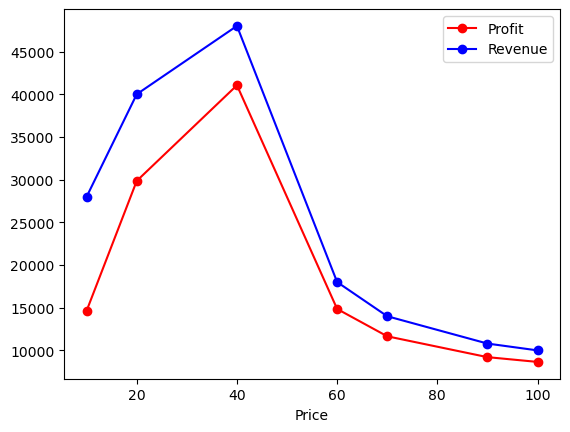

In [8]:
# plot revenue and profit measured data:
plt.plot(pricing_df["price"], pricing_df["profit"], color="red", marker="o", label="Profit")
plt.plot(pricing_df["price"], pricing_df["revenue"], color="blue", marker="o", label="Revenue")
plt.legend()
plt.xlabel("Price")
plt.show()

## Polynomial fit

### Price optimization based on Revenue

28


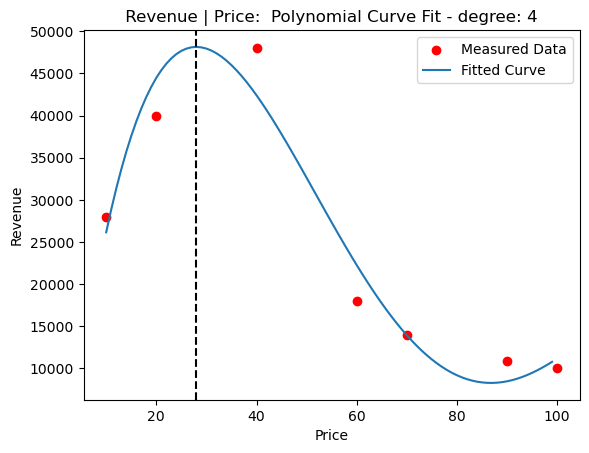

In [21]:
degree = 4

curve_fit = np.polyfit(
    pricing_df["price"].values, pricing_df["revenue"].values, deg=degree
)

x_plot = np.arange(10, 100)
y_plot = np.polyval(curve_fit, x_plot)

plt.scatter(pricing_df["price"], pricing_df["revenue"], color="red", marker="o", label='Measured Data')
plt.plot(x_plot, y_plot, label='Fitted Curve')

plt.title(f" Revenue | Price:  Polynomial Curve Fit - degree: {degree} ")

plt.ylabel("Revenue")
plt.xlabel("Price")
plt.legend()

index = np.argmax(y_plot)
print(x_plot[index])


plt.axvline(x=x_plot[index], color='black', linestyle='--')

plt.show()

### Price optimization based on Profit

30


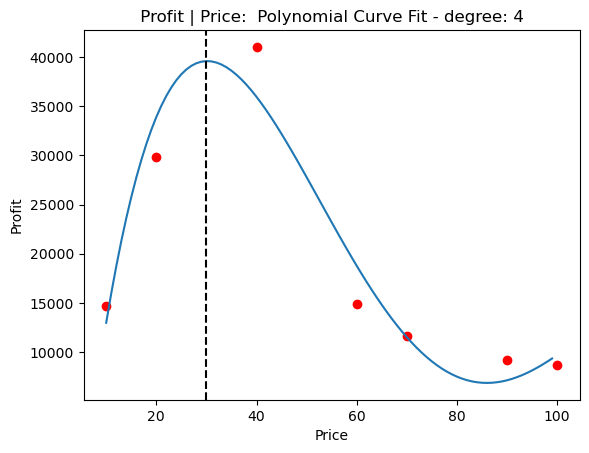

In [22]:
curve_fit = np.polyfit(
    pricing_df["price"].values, pricing_df["profit"].values, deg=degree
)

x_plot = np.arange(10, 100)
y_plot = np.polyval(curve_fit, x_plot)

plt.scatter(pricing_df["price"], pricing_df["profit"], color="red", marker="o", label='Measured Data')
plt.plot(x_plot, y_plot, label='Fitted Curve')

plt.title(f" Profit | Price:  Polynomial Curve Fit - degree: {degree} ")

plt.ylabel("Profit")
plt.xlabel("Price")



index = np.argmax(y_plot)
print(x_plot[index])

plt.axvline(x=x_plot[index], color='black', linestyle='--')

plt.show()

## Linear Modeling

In [11]:
x_value = np.log(pricing_df.price)
y_value = np.log(pricing_df.demand)
X = add_constant(x_value)
model = sm.OLS(y_value, X)
result = model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     46.87
Date:                Thu, 30 Nov 2023   Prob (F-statistic):            0.00102
Time:                        16:14:44   Log-Likelihood:                -3.4367
No. Observations:                   7   AIC:                             10.87
Df Residuals:                       5   BIC:                             10.77
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.9628      0.868     13.785      0.0

/Users/man-top/miniconda3/envs/NYRKR/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


The small P values ( <= 0.001 ) indicate that we can reject the null hypothesis that Price does not affect Quantity.

In [12]:
coefficient_pvalue = result.f_pvalue
loga, slope = result.params

In [13]:
a = round(math.exp(loga), 0)

# Set price range
price = list(np.linspace(10, 100, num=1000))
demand = a * np.power(price, slope)

revenue = price * demand
max_revenue = np.max(revenue)
max_index = np.argmax(revenue)
price[max_index]

10.0

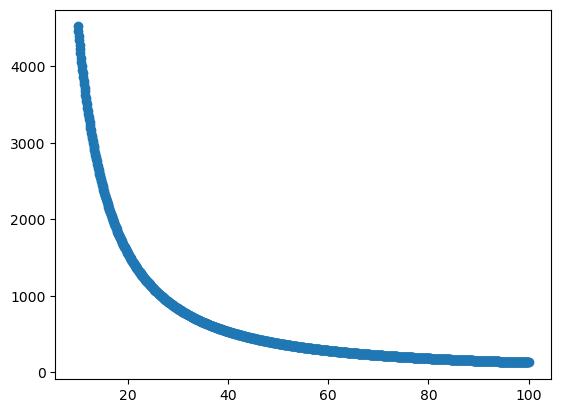

In [14]:
plt.scatter(x=price, y=demand);


## Bayesian modeling

In [15]:
p0 = pricing_df.price
q0 = pricing_df.demand

with pm.Model() as m:
    a = pm.Normal("a", 0, 7)
    b = pm.Normal("b", 0, 7)
    logm0 = a + b * (np.log(p0))
    m0 = pm.Deterministic("m0", np.exp(logm0))
    qval = pm.Poisson("q0", m0, observed=q0)

with m:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [16]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,10.776,0.046,10.684,10.859,0.002,0.001,885.0,988.0,1.01
b,-1.159,0.015,-1.186,-1.130,0.001,0.000,918.0,1055.0,1.01
m0[0],229.766,6.378,218.289,241.726,0.182,0.128,1234.0,1662.0,1.00
m0[1],259.610,6.840,247.128,272.177,0.192,0.136,1266.0,1844.0,1.00
m0[2],347.402,8.012,332.995,362.423,0.216,0.153,1376.0,1973.0,1.00
m0[3],415.368,8.779,399.137,431.491,0.228,0.162,1475.0,2041.0,1.00
m0[4],664.602,11.007,643.373,684.005,0.249,0.176,1948.0,2469.0,1.00
m0[5],1484.425,18.384,1449.321,1518.174,0.327,0.231,3148.0,2857.0,1.00
m0[6],3315.910,52.651,3222.661,3416.744,1.507,1.066,1219.0,1786.0,1.00


array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'm0'}>, <Axes: title={'center': 'm0'}>]],
      dtype=object)

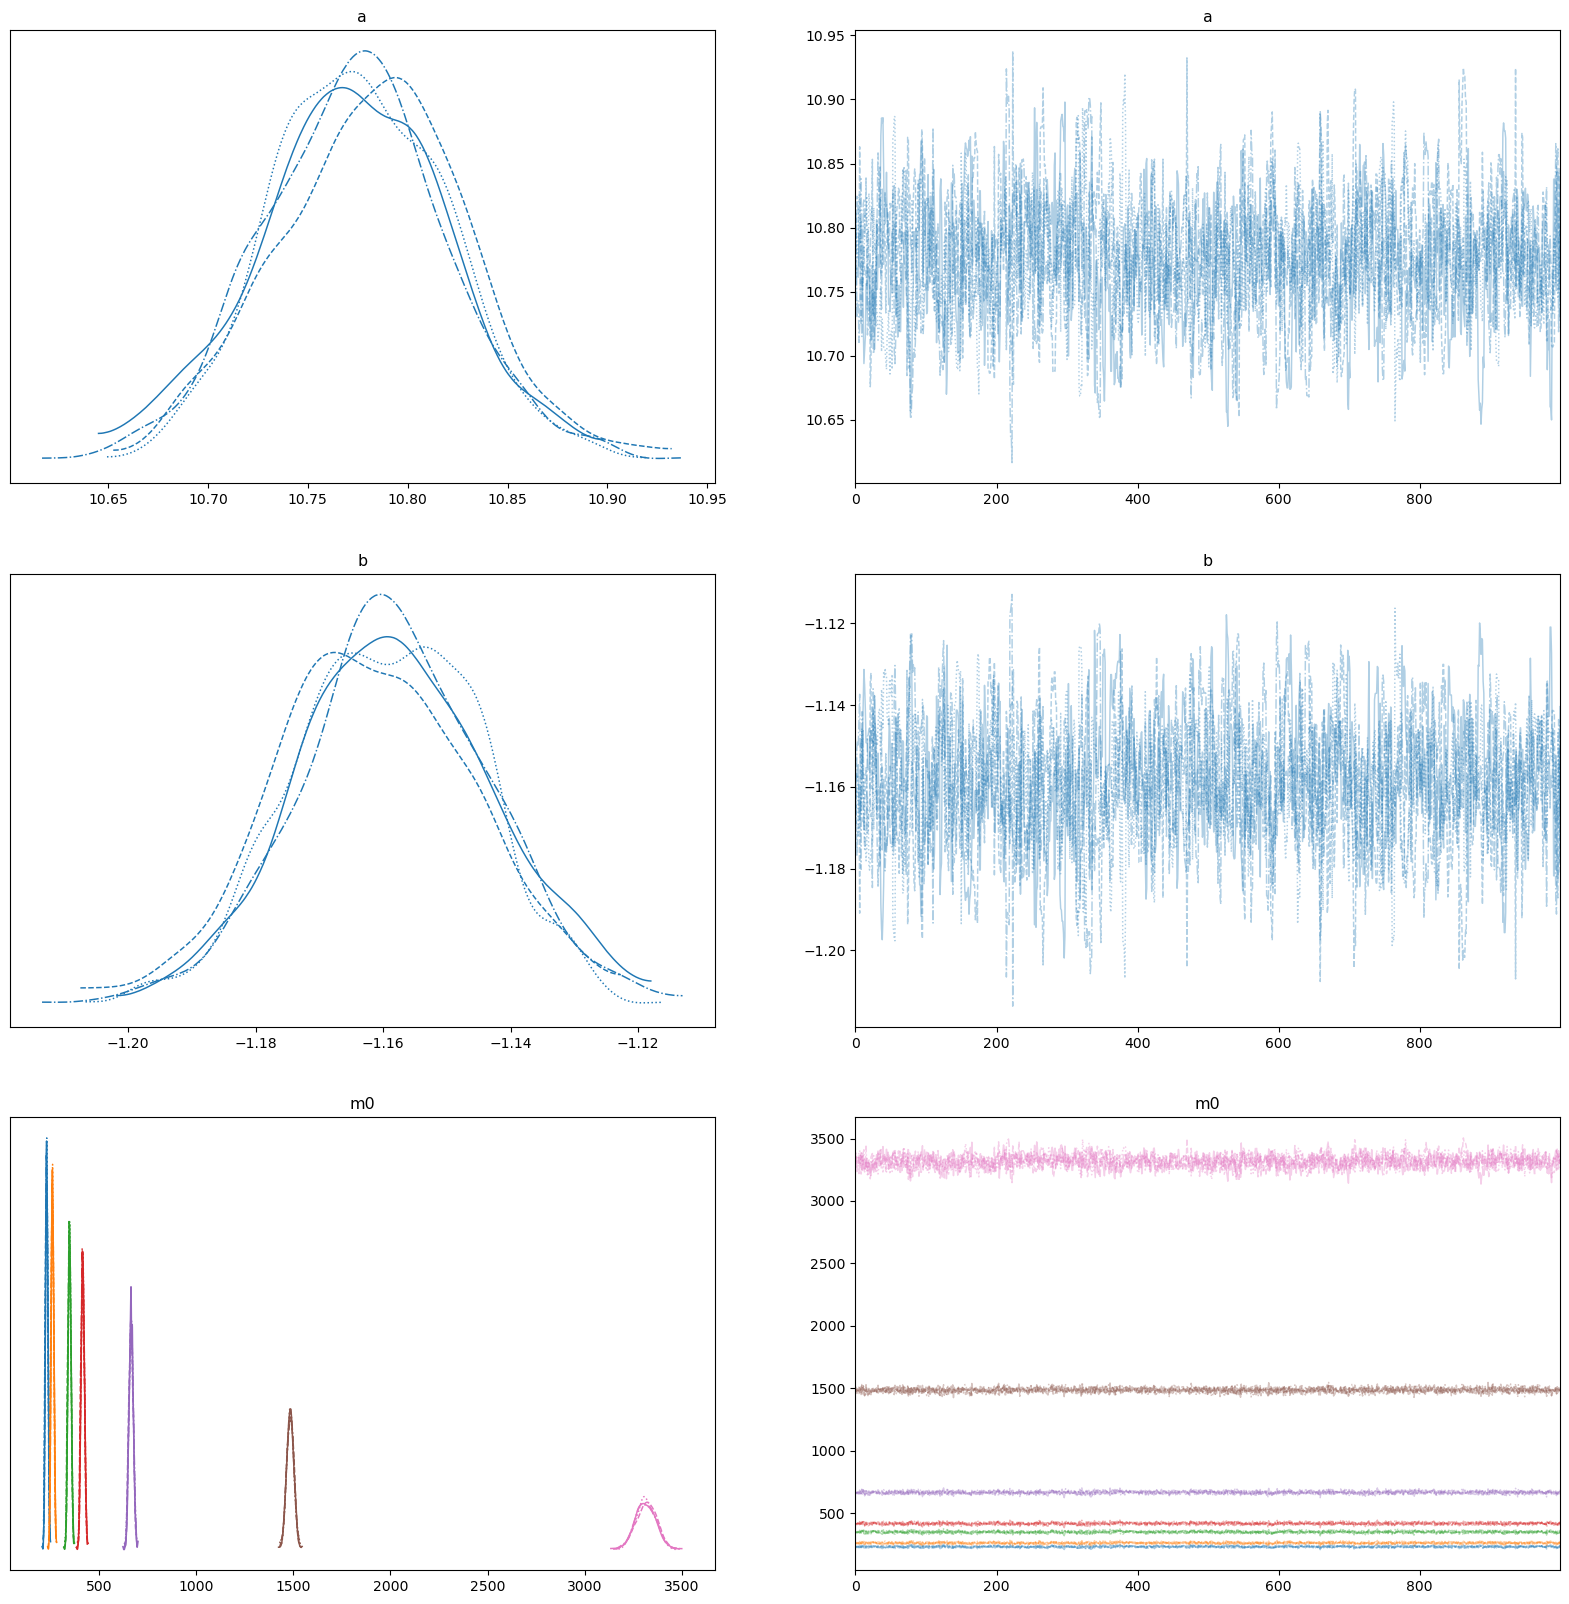

In [17]:
pm.plot_trace(trace, figsize=(20, 20))

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

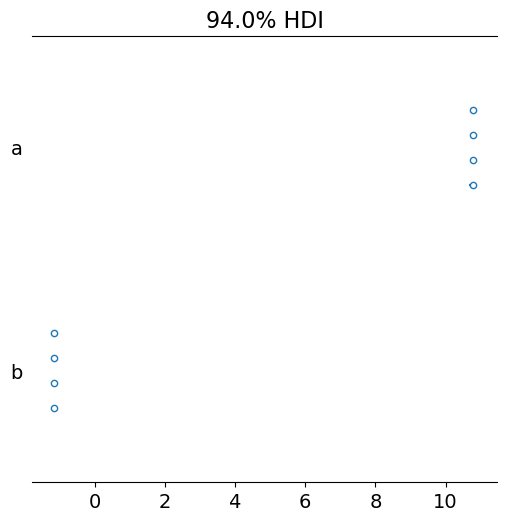

In [18]:
pm.plot_forest(trace, var_names=["a", "b"])

In [19]:
# extracting all posterior values:
A = []
for i in range(4):
    A.append(np.array(trace.posterior.a[i]))
arr_a = np.concatenate(tuple(A))

B = []
for i in range(4):
    B.append(np.array(trace.posterior.b[i]))
arr_b = np.concatenate(tuple(B))

Text(0, 0.5, 'Demand')

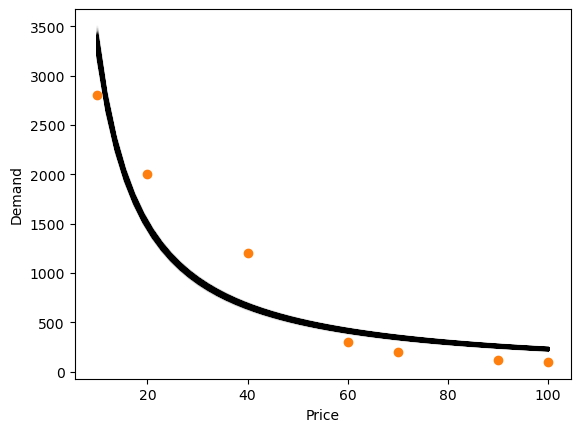

In [20]:
p = np.linspace(10, 100)
i = 1

a = arr_a.reshape(1, -1)
b = arr_b.reshape(1, -1)

mu = np.exp(a + b * (np.log(p).reshape(-1, 1)))

plt.plot(p, mu, c="k", alpha=0.01)
plt.plot(p0, q0, "o", c="C1")
plt.xlabel("Price")
plt.ylabel("Demand")